In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

model = tf.keras.applications.VGG19(include_top=False,weights='imagenet')#load vgg model and remove 3 FC layers

80142336/80134624 [==============================] - 3s 0us/step


In [3]:
model.trainable=False#freeze all the weights
model.summary()#layer summary

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [93]:
def preprocess(img_path):
  image=tf.keras.preprocessing.image.load_img(img_path,target_size=(224,224))#load image
  img_array=tf.keras.preprocessing.image.img_to_array(image)#convert to numpy array
  image=tf.keras.applications.vgg19.preprocess_input(img_array)#RBG->BRG and 0 center all pixels
  processed_image=np.expand_dims(image,axis=0)#adding the no. of examples parameter(m) at the start
  return processed_image

In [5]:
def deprocess(image):
  #inversing the preprocessing step
  image[:, :, 0] += 103.939
  image[:, :, 1] += 116.779
  image[:, :, 2] += 123.68
  image=image[:, :, ::-1]#reversing the array
  image=np.clip(image,0,255).astype('uint8')#limiting pixel values 
  return image

In [6]:
def display(image):
  if len(image.shape)>3:
    image=np.squeeze(image,axis=0)#to remove the 'm'
    image=deprocess(image) 
    plt.imshow(image)#display image

(1, 224, 224, 3)

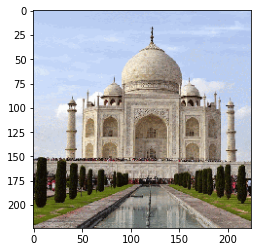

In [159]:
image=preprocess('taj.gif')
display(image)
image.shape


(1, 224, 224, 3)

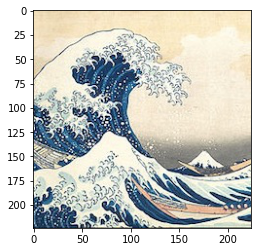

In [160]:
image=preprocess('style.jpg')
display(image)
image.shape

In [123]:
#activations of these layers are used
content_layer = 'block5_conv2'
style_layer = [
               'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

In [10]:
from tensorflow.python.keras.models import Model

In [11]:
content_model=Model(
    inputs=model.input,#input will be our image
    outputs=model.get_layer(content_layer).output#output will be from our chose activation layer
)

style_model=[Model(
    inputs=model.input,#input will be our image
    outputs=model.get_layer(i).output) for i in style_layer]#iterating through all our chosen activation layers


In [12]:
def content_cost(content,generated):
  a_c=content_model(content)#passing content image to content model to get activations
  a_g=content_model(generated)#passing generated image to content model to get activations
  content_loss = tf.reduce_mean(tf.square(tf.subtract(a_c,a_g)))#mean((a_c-a_g))**2
  return content_loss

In [13]:
def gram_matrix(A):
  A=tf.reshape(A,[-1,A.shape[-1]])#unrolling A to (w*b,channel)
  n=A.shape[0]#for scaling
  gram=tf.matmul(A,A,transpose_a=True)#gram matrix
  gram = gram/tf.cast(n,tf.float32)#scaling
  return gram

In [153]:
def style_cost(style,generated):
  layerweight=[1,1,40,40,10]
  style_loss=0
  i=0
  for layer in style_model:#iterating through all layers
    a_s=layer(style)#passing style image to content model to get activations
    a_g=layer(generated)#passing generated image to content model to get activations
    G_s=gram_matrix(a_s)#Gram matrix for style activations
    G_g=gram_matrix(a_g)#Gram matrix for generated activations
    layer_loss = tf.reduce_mean(tf.square(tf.subtract(G_s,G_g)))#mean((G_s-G_g))**2
    style_loss+=layerweight[i]*layer_loss#factor by which each layer should affect the generated image
    i+=1
  return style_loss  

In [175]:
generated_images=[]#list to store intermediate images
def training(content,style,alpha=10,beta=20):
  content=preprocess(content)
  style=preprocess(style)
  generated=tf.Variable(initial_value=content)#initialising generated image to content image
  opt = tf.keras.optimizers.Adam(learning_rate=4.)#adam optimization algorithm is used
  
  for i in range(20):
    with tf.GradientTape() as tape:#used for diffrentiation of custom costs
      cost_content=content_cost(content,generated)
      cost_style=style_cost(style,generated)
      total_cost=alpha*cost_content+beta*cost_style
      gradients = tape.gradient(total_cost, generated)#getting derivate of total cost wrt all pixels of generated image
      opt.apply_gradients([(gradients, generated)])#gradient descent
      generated_images.append(generated.numpy())
      print(i,total_cost)
  return generated.numpy()    


In [176]:
final=training('taj.gif','style.jpg')

0 tf.Tensor(236341180000000.0, shape=(), dtype=float32)
1 tf.Tensor(151636570000000.0, shape=(), dtype=float32)
2 tf.Tensor(92225270000000.0, shape=(), dtype=float32)
3 tf.Tensor(61703304000000.0, shape=(), dtype=float32)
4 tf.Tensor(50327856000000.0, shape=(), dtype=float32)
5 tf.Tensor(43884130000000.0, shape=(), dtype=float32)
6 tf.Tensor(40571385000000.0, shape=(), dtype=float32)
7 tf.Tensor(38407800000000.0, shape=(), dtype=float32)
8 tf.Tensor(34958861000000.0, shape=(), dtype=float32)
9 tf.Tensor(30964049000000.0, shape=(), dtype=float32)
10 tf.Tensor(27587141000000.0, shape=(), dtype=float32)
11 tf.Tensor(24711851000000.0, shape=(), dtype=float32)
12 tf.Tensor(22236837000000.0, shape=(), dtype=float32)
13 tf.Tensor(20365718000000.0, shape=(), dtype=float32)
14 tf.Tensor(19017065000000.0, shape=(), dtype=float32)
15 tf.Tensor(17731066000000.0, shape=(), dtype=float32)
16 tf.Tensor(16350095000000.0, shape=(), dtype=float32)
17 tf.Tensor(15122632000000.0, shape=(), dtype=float32)


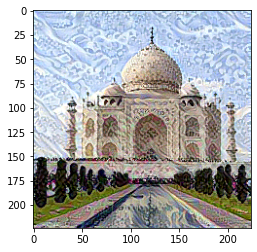

In [177]:
display(final)